In [37]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [38]:
#creating a csv file similar to the assignment one
with open("./bbc-text-raw.csv", 'r') as csvfileR:
    with open("./bbc-text.csv", 'w', newline='') as csvfileW:
      reader = csv.reader(csvfileR, delimiter=",")
      writer = csv.writer(csvfileW, delimiter=',')
      for row in reader:
         #writer.writerow(row[2],row[1])
         writer.writerow([str(row[2]), str(row[1])])

In [39]:
with open("./bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

Category,Text

Each data point looks like this:

business,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she s

In [40]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [41]:
def remove_stopwords(sentence):
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [42]:
# Test the functions
sentences, labels = parse_data_from_file("./bbc-text.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 1490 sentences in the dataset.

First sentence has 203 words (after removing stopwords).

There are 1490 labels in the dataset.

The first 5 labels are ['business', 'business', 'business', 'tech', 'business']


In [43]:
# GRADED FUNCTIONS: train_val_split
def train_val_split(sentences, labels, training_split):
    
    ### START CODE HERE
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [44]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1192 sentences for training.

There are 1192 labels for training.

There are 298 sentences for validation.

There are 298 labels for validation.


In [45]:
# GRADED FUNCTION: fit_tokenizer
def fit_tokenizer(train_sentences, num_words, oov_token):
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)    
    
    ### END CODE HERE
    
    return tokenizer

In [46]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 22647 words

<OOV> token included in vocabulary


In [47]:
# GRADED FUNCTION: seq_and_pad
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    
    ### START CODE HERE
    
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    
    ### END CODE HERE
    
    return padded_sequences

In [48]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1192, 120)

Padded validation sequences have shape: (298, 120)


In [55]:
# GRADED FUNCTION: tokenize_labels
def tokenize_labels(all_labels, split_labels):
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels

    label_tokenizer.fit_on_texts(all_labels)    
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1
    #label_seq_np = np.array(label_seq)
    
    ### END CODE HERE
    
    return label_seq_np

In [56]:
# Test your function
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [1]
 [1]
 [4]
 [1]]

First 5 labels of the validation set should look like this:
[[3]
 [3]
 [2]
 [1]
 [4]]

Tokenized labels of the training set have shape: (1192, 1)

Tokenized labels of the validation set have shape: (298, 1)



In [57]:
# GRADED FUNCTION: create_model
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [58]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
38/38 [==============================] - 4s 12ms/step - loss: 1.6019 - accuracy: 0.3305 - val_loss: 1.5932 - val_accuracy: 0.3624
Epoch 2/30
38/38 [==============================] - 0s 7ms/step - loss: 1.5778 - accuracy: 0.4211 - val_loss: 1.5625 - val_accuracy: 0.4228
Epoch 3/30
38/38 [==============================] - 0s 7ms/step - loss: 1.5316 - accuracy: 0.4614 - val_loss: 1.5052 - val_accuracy: 0.4396
Epoch 4/30
38/38 [==============================] - 0s 8ms/step - loss: 1.4490 - accuracy: 0.4698 - val_loss: 1.4115 - val_accuracy: 0.4329
Epoch 5/30
38/38 [==============================] - 0s 9ms/step - loss: 1.3266 - accuracy: 0.4648 - val_loss: 1.2895 - val_accuracy: 0.4262
Epoch 6/30
38/38 [==============================] - 0s 7ms/step - loss: 1.1897 - accuracy: 0.4740 - val_loss: 1.1640 - val_accuracy: 0.4530
Epoch 7/30
38/38 [==============================] - 0s 7ms/step - loss: 1.0588 - accuracy: 0.5218 - val_loss: 1.0472 - val_accuracy: 0.5570
Epoch 8/30
38/38 [=

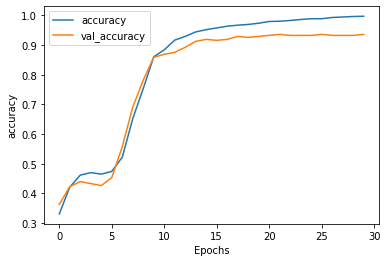

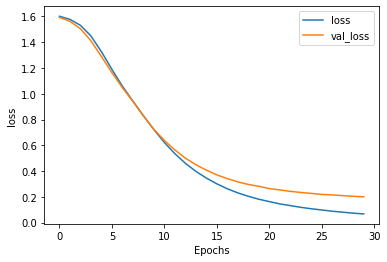

In [59]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")